<a href="https://colab.research.google.com/github/chang-heekim/Oxford-Pet-Dataset/blob/main/Oxford_Pet_Dataset_Semantic_Segmenatiation_2_Class_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from glob import glob
from datetime import datetime
import cv2

from torch.utils.data import Dataset
from PIL import Image
import torch

from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch import nn, optim
from torchsummary import summary
import torch.nn.functional as F

# Setting device &  Data Preprocessing

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [3]:
df = pd.read_csv('/content/drive/MyDrive/dataset/oxford_pet/annotations/list.txt', skiprows=6, delimiter=' ', header=None)
df.columns = ['file_name', 'id', 'species', 'breed']
df.head()

file_name  id  species  breed
0  Abyssinian_100   1        1      1
1  Abyssinian_101   1        1      1
2  Abyssinian_102   1        1      1
3  Abyssinian_103   1        1      1
4  Abyssinian_104   1        1      1

In [4]:
image_dir = '/content/drive/MyDrive/dataset/oxford_pet/images/'
seg_dir = '/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/'

In [5]:
image_files = glob(image_dir + '*.jpg')
seg_files = glob(seg_dir + '*.png')
len(image_files), len(seg_files)

(7378, 7390)

In [6]:
seg_path = []
i = 0
for idx, img_file in enumerate(image_files):
    seg = img_file.replace(image_dir, seg_dir).replace('jpg', 'png')
    if seg in seg_files:
        seg_path.append(seg)
    else:
        image_files.pop(idx - i)
        i += 1

len(image_files), len(seg_path)

(7378, 7378)

In [7]:
image_files[:10], seg_path[:10]

(['/content/drive/MyDrive/dataset/oxford_pet/images/shiba_inu_12.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/wheaten_terrier_137.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/Bengal_88.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/keeshond_170.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/newfoundland_107.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/japanese_chin_106.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/Birman_49.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/Sphynx_90.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/Persian_126.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/japanese_chin_105.jpg'],
 ['/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/shiba_inu_12.png',
  '/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/wheaten_terrier_137.png',
  '/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/Bengal_88.png',
  '/content/drive/MyDr

# Define Dataset & Visualization

In [8]:
class Oxford_Segmentation_Dataset(Dataset):
    def __init__(self, img_dir, seg_path, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.seg_path = seg_path
        
    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        seg_path = self.seg_path[idx]
        seg = np.array(Image.open(seg_path))
        seg[seg != 1] = 0

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            seg = self.target_transform(seg)
            seg = np.array(seg)
            seg = torch.unsqueeze(torch.tensor(seg.astype('float32')), 0)
    
        return image, seg

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
])

dataset = Oxford_Segmentation_Dataset(
    img_dir=image_files, 
    seg_path=seg_path, 
    transform=transform, 
    target_transform=target_transform
)

train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
train_batch_size = 32
val_batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2)

In [11]:
for idx, sample_batch in enumerate(train_loader):
    print(sample_batch[0].shape)
    print(sample_batch[1].shape)
    print(sample_batch[0].dtype)
    print(sample_batch[1].dtype)
    print()
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 1, 224, 224])
torch.float32
torch.float32



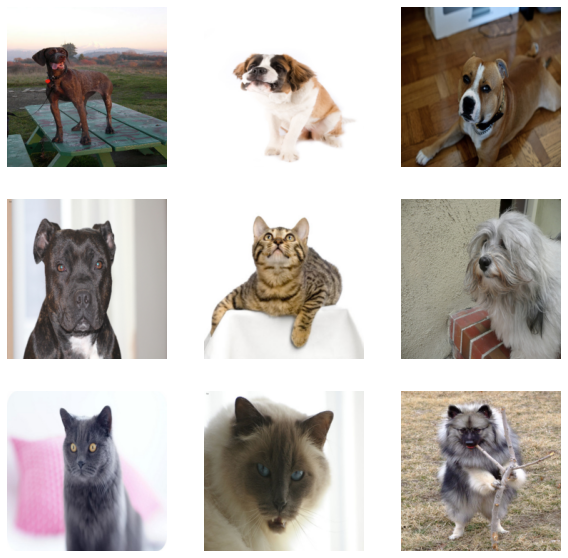

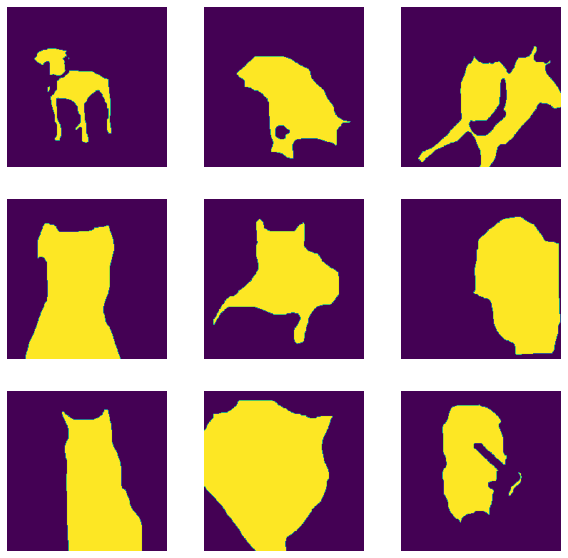

In [12]:
sample = next(iter(val_loader))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(torch.permute(sample[0][i], (1, 2, 0)))
    plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(torch.squeeze(sample[1][i], 0))
    plt.axis('off')
plt.show()

# Define UNet & Optimizer & Dice Loss function & IOU

In [13]:
class DConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.dconv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.dconv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.max_pool = nn.MaxPool2d(2)

        self.enc1 = DConv(in_channels, 64)
        self.enc2 = DConv(64, 128)
        self.enc3 = DConv(128, 256)
        self.enc4 = DConv(256, 512)
        
        self.enc5 = nn.Conv2d(512, 1024, 3, 1, 1)
        self.dec5 = nn.Conv2d(1024, 512, 3, 1, 1)

        self.up_pool_4 = nn.ConvTranspose2d(512, 512, 2, 2, 0)
        self.dec4 = DConv(1024, 512)

        self.up_pool_3 = nn.ConvTranspose2d(512, 256, 2, 2, 0)
        self.dec3 = DConv(512, 256)

        self.up_pool_2 = nn.ConvTranspose2d(256, 128, 2, 2, 0)
        self.dec2 = DConv(256, 128)

        self.up_pool_1 = nn.ConvTranspose2d(128, 64, 2, 2, 0)
        self.dec1 = DConv(128, 64)

        self.conv = nn.Conv2d(64, out_channels, 1, 1, 0)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        pool1 = self.max_pool(enc1)
        enc2 = self.enc2(pool1)
        pool2 = self.max_pool(enc2)
        enc3 = self.enc3(pool2)
        pool3 = self.max_pool(enc3)
        enc4 = self.enc4(pool3)
        pool4 = self.max_pool(enc4)
        
        enc5 = self.enc5(pool4)
        dec5 = self.dec5(enc5)

        up_pool4 = self.up_pool_4(dec5)
        cat4 = torch.cat((up_pool4, enc4), dim=1)
        dec4 = self.dec4(cat4)

        up_pool3 = self.up_pool_3(dec4)
        cat3 = torch.cat((up_pool3, enc3), dim=1)
        dec3 = self.dec3(cat3)

        up_pool2 = self.up_pool_2(dec3)
        cat2 = torch.cat((up_pool2, enc2), dim=1)
        dec2 = self.dec2(cat2)

        up_pool1 = self.up_pool_1(dec2)
        cat1 = torch.cat((up_pool1, enc1), dim=1)
        dec1 = self.dec1(cat1)

        out = self.conv(dec1)
        out = torch.sigmoid(out)

        return out

In [14]:
def iou(preds, targets):
    smooth = 1e-5

    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    intersection = np.sum(np.logical_and(targets, preds))
    union = np.sum(np.logical_or(targets, preds))
    iou_score = (torch.tensor(intersection) + smooth)  / (torch.tensor(union) + smooth)

    return iou_score

def dice_coef(preds, targets):
    smooth = 1e-5

    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    intersection = np.sum(np.logical_and(targets, preds))
    union = np.sum(np.logical_or(targets, targets)) + np.sum(np.logical_or(preds, preds))
    dice = (2 * torch.tensor(intersection) + smooth) / (torch.tensor(union) + smooth )
    return dice
    

def dice_loss(preds, targets):
    return 1 - dice_coef(targets, preds)

def bce_dice_loss(preds, targets):
    loss_fn = nn.BCELoss()
    loss = 1. * loss_fn(preds, targets) + 1. * dice_loss(preds, targets)

    return loss

In [15]:
lr = 1e-2
epochs = 30

model = UNet(3, 1).to(device)
model_name = type(model).__name__
summary(model, (3, 224, 224))

loss_fn = bce_dice_loss

optimizer = optim.Adam(model.parameters(), lr=lr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
             DConv-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,728
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,456
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

# Define Training & Validation Function

In [16]:
def train(epoch, model, train_loader, loss_fn, optimizer):
    print(f' Epoch: [{epoch}/{epochs}] - Train')
    model.train()
    current_loss = 0.0
    current_iou = 0.0
    for batch_idx, (images, mask) in enumerate(train_loader):
        images, mask = images.to(device), mask.to(device)

        outputs = model(images)

        loss = loss_fn(outputs, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = (outputs >= 0.5).int()

        current_loss += loss.item()
        current_iou += iou(outputs, mask)

        if (batch_idx + 1) % 50 == 0:
            train_loss = current_loss / 50
            train_iou = current_iou / 50
            print(f'Current Step: {batch_idx + 1} \tTrain Loss: {train_loss}, Train Iou: {train_iou}')

            current_loss = 0.0
            current_iou = 0.0

    return train_loss, train_iou

def validation(epoch, model, val_loader, loss_fn):
    print(f' Epoch: [{epoch}/{epochs}] - Validation')
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        for val_idx, (val_images, val_mask) in enumerate(val_loader):

            val_images, val_mask = val_images.to(device), val_mask.to(device)
            val_outputs = model(val_images)

            val_loss += loss_fn(val_outputs, val_mask)

            val_outputs = (val_outputs >= 0.5).int()
            
            val_iou += iou(val_outputs, val_mask)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_iou = val_iou / len(val_loader)

    print(f'Validation step: Val Loss: {val_epoch_loss}, Val Iou: {val_epoch_iou}')

    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.imshow(torch.permute(val_images[0], (1, 2, 0)).detach().cpu().numpy())
    plt.title('Image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(torch.squeeze(torch.squeeze(val_mask[0], 0), 0).detach().cpu().numpy())
    plt.title('Seg Map')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(torch.squeeze(torch.squeeze(val_outputs[0], 0), 0).detach().cpu().numpy())
    plt.title('Predict')
    plt.axis('off')
    plt.show()

    return val_epoch_loss, val_epoch_iou

# Training

 Epoch: [1/30] - Train
Current Step: 50 	Train Loss: 1.034195247888565, Train Iou: 0.3049401342868805
Current Step: 100 	Train Loss: 0.9779099297523498, Train Iou: 0.4541218876838684
Current Step: 150 	Train Loss: 0.9720132279396058, Train Iou: 0.4585801064968109
Current Step: 200 	Train Loss: 0.9619018745422363, Train Iou: 0.47144630551338196
 Epoch: [1/30] - Validation
Validation step: Val Loss: 0.9579598903656006, Val Iou: 0.41061314940452576


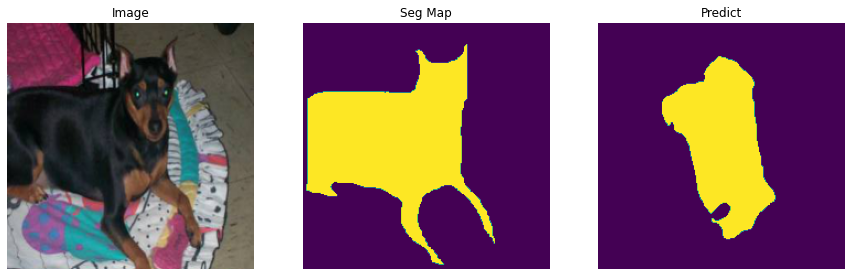

 Epoch: [2/30] - Train
Current Step: 50 	Train Loss: 0.9505522310733795, Train Iou: 0.48855477571487427
Current Step: 100 	Train Loss: 0.9332910931110382, Train Iou: 0.5083094239234924
Current Step: 150 	Train Loss: 0.9291041231155396, Train Iou: 0.5191885828971863
Current Step: 200 	Train Loss: 0.9201805651187897, Train Iou: 0.5396261811256409
 Epoch: [2/30] - Validation
Validation step: Val Loss: 0.9745959639549255, Val Iou: 0.4007847011089325


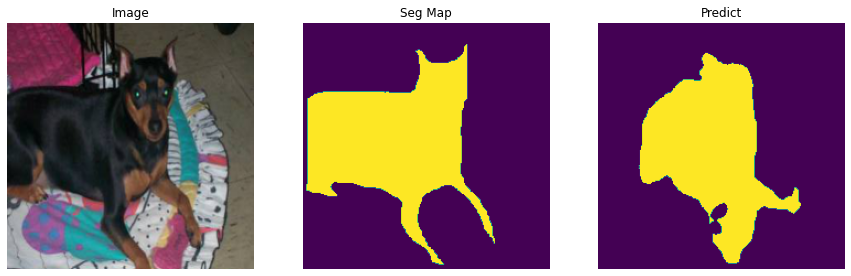

 Epoch: [3/30] - Train
Current Step: 50 	Train Loss: 0.9201122713088989, Train Iou: 0.5335716009140015
Current Step: 100 	Train Loss: 0.9088026225566864, Train Iou: 0.5482404232025146
Current Step: 150 	Train Loss: 0.8971332156658173, Train Iou: 0.5616443753242493
Current Step: 200 	Train Loss: 0.8861779129505157, Train Iou: 0.5770142078399658
 Epoch: [3/30] - Validation
Validation step: Val Loss: 1.1748440265655518, Val Iou: 0.1603829264640808


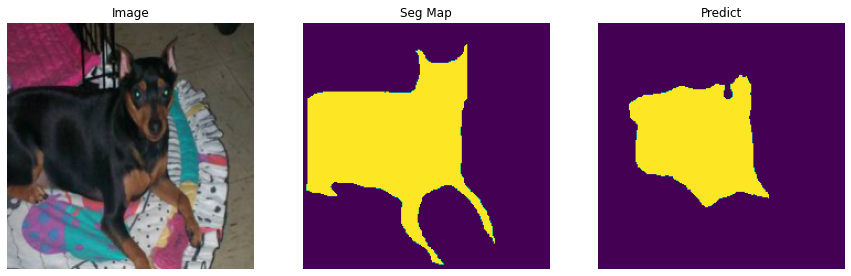

 Epoch: [4/30] - Train
Current Step: 50 	Train Loss: 0.8771880233287811, Train Iou: 0.588514506816864
Current Step: 100 	Train Loss: 0.8670752811431884, Train Iou: 0.599332869052887
Current Step: 150 	Train Loss: 0.8472964906692505, Train Iou: 0.6234467029571533
Current Step: 200 	Train Loss: 0.8536606097221374, Train Iou: 0.6198346614837646
 Epoch: [4/30] - Validation
Validation step: Val Loss: 0.8834190368652344, Val Iou: 0.536676287651062


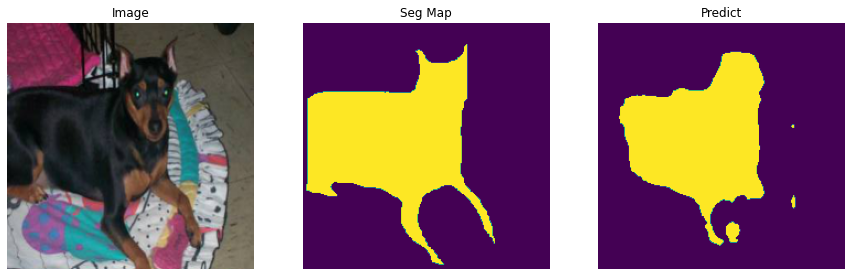

 Epoch: [5/30] - Train
Current Step: 50 	Train Loss: 0.8415754413604737, Train Iou: 0.63034987449646
Current Step: 100 	Train Loss: 0.839597806930542, Train Iou: 0.6354242563247681
Current Step: 150 	Train Loss: 0.8300581014156342, Train Iou: 0.6476262807846069
Current Step: 200 	Train Loss: 0.8283785665035248, Train Iou: 0.6468360424041748
 Epoch: [5/30] - Validation
Validation step: Val Loss: 0.8297209143638611, Val Iou: 0.6680817604064941


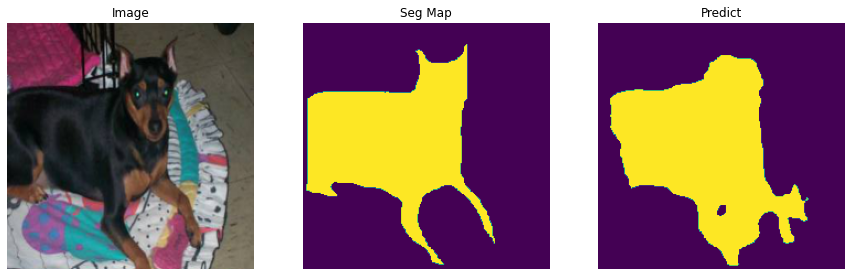

 Epoch: [6/30] - Train
Current Step: 50 	Train Loss: 0.8091427397727966, Train Iou: 0.6732293963432312
Current Step: 100 	Train Loss: 0.81596240401268, Train Iou: 0.6620199680328369
Current Step: 150 	Train Loss: 0.8125800025463105, Train Iou: 0.6711329817771912
Current Step: 200 	Train Loss: 0.8022669208049774, Train Iou: 0.6829202771186829
 Epoch: [6/30] - Validation
Validation step: Val Loss: 0.8164710998535156, Val Iou: 0.6587163209915161


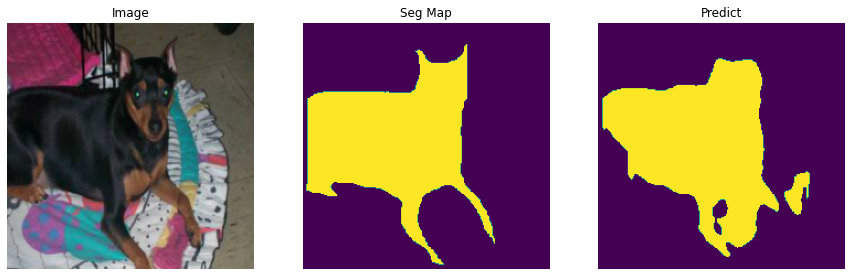

 Epoch: [7/30] - Train
Current Step: 50 	Train Loss: 0.7892655324935913, Train Iou: 0.6932973265647888
Current Step: 100 	Train Loss: 0.7862803494930267, Train Iou: 0.6978940367698669
Current Step: 150 	Train Loss: 0.7872848665714264, Train Iou: 0.7012386322021484
Current Step: 200 	Train Loss: 0.7837261879444122, Train Iou: 0.7021926045417786
 Epoch: [7/30] - Validation
Validation step: Val Loss: 0.775258481502533, Val Iou: 0.7192144393920898


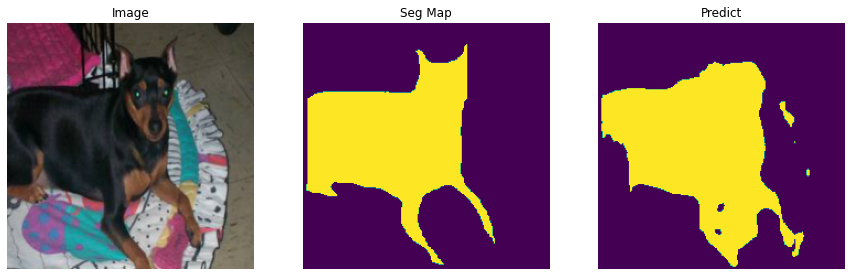

 Epoch: [8/30] - Train
Current Step: 50 	Train Loss: 0.7786360216140747, Train Iou: 0.7128667235374451
Current Step: 100 	Train Loss: 0.7669861030578613, Train Iou: 0.7249796986579895
Current Step: 150 	Train Loss: 0.7684345972537995, Train Iou: 0.7189346551895142
Current Step: 200 	Train Loss: 0.7622321426868439, Train Iou: 0.728334367275238
 Epoch: [8/30] - Validation
Validation step: Val Loss: 0.7696845531463623, Val Iou: 0.7244099378585815


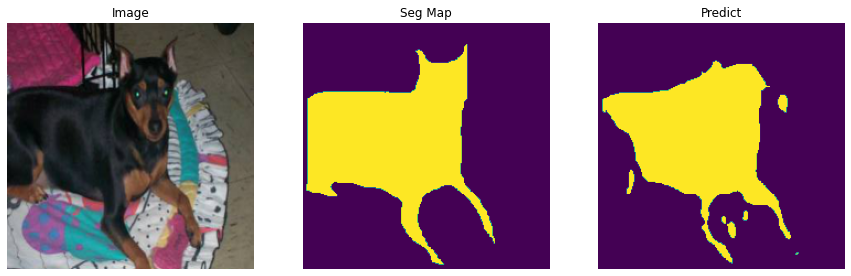

 Epoch: [9/30] - Train
Current Step: 50 	Train Loss: 0.75472616314888, Train Iou: 0.7348397970199585
Current Step: 100 	Train Loss: 0.7615464365482331, Train Iou: 0.7336344718933105
Current Step: 150 	Train Loss: 0.7595132601261139, Train Iou: 0.7327924370765686
Current Step: 200 	Train Loss: 0.7513480389118194, Train Iou: 0.7398984432220459
 Epoch: [9/30] - Validation
Validation step: Val Loss: 0.7527148127555847, Val Iou: 0.7308510541915894


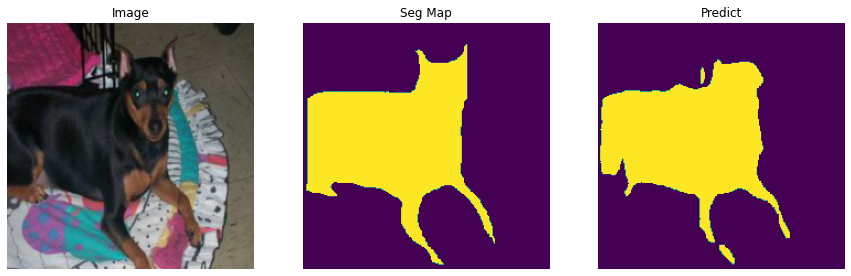

 Epoch: [10/30] - Train
Current Step: 50 	Train Loss: 0.7462292075157165, Train Iou: 0.7491241693496704
Current Step: 100 	Train Loss: 0.7415795290470123, Train Iou: 0.7509956359863281
Current Step: 150 	Train Loss: 0.7390860855579376, Train Iou: 0.7539530396461487
Current Step: 200 	Train Loss: 0.7543257451057435, Train Iou: 0.7460623383522034
 Epoch: [10/30] - Validation
Validation step: Val Loss: 0.7700315713882446, Val Iou: 0.6836646199226379


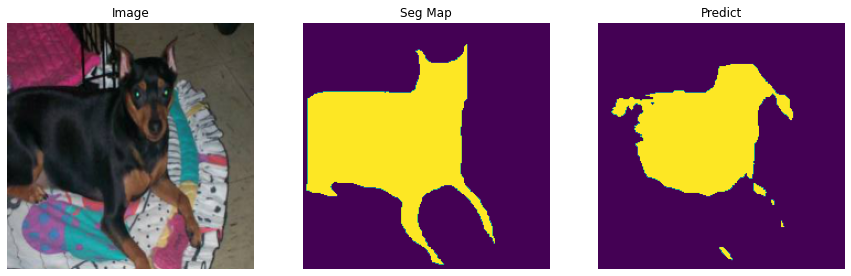

 Epoch: [11/30] - Train
Current Step: 50 	Train Loss: 0.7363774609565735, Train Iou: 0.7652984857559204
Current Step: 100 	Train Loss: 0.7338181817531586, Train Iou: 0.7647098302841187
Current Step: 150 	Train Loss: 0.7268617939949036, Train Iou: 0.7695465683937073
Current Step: 200 	Train Loss: 0.732201156616211, Train Iou: 0.7592914700508118
 Epoch: [11/30] - Validation
Validation step: Val Loss: 0.7415375113487244, Val Iou: 0.7417450547218323


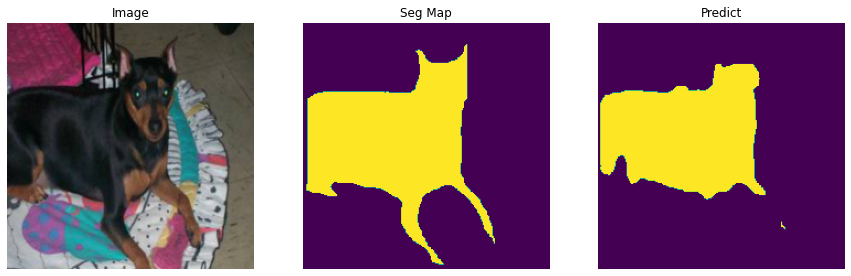

 Epoch: [12/30] - Train
Current Step: 50 	Train Loss: 0.7137043535709381, Train Iou: 0.7828513383865356
Current Step: 100 	Train Loss: 0.7234822976589202, Train Iou: 0.7739603519439697
Current Step: 150 	Train Loss: 0.7305931115150451, Train Iou: 0.7671784162521362
Current Step: 200 	Train Loss: 0.7278379619121551, Train Iou: 0.7736424803733826
 Epoch: [12/30] - Validation
Validation step: Val Loss: 0.711544394493103, Val Iou: 0.7796878218650818


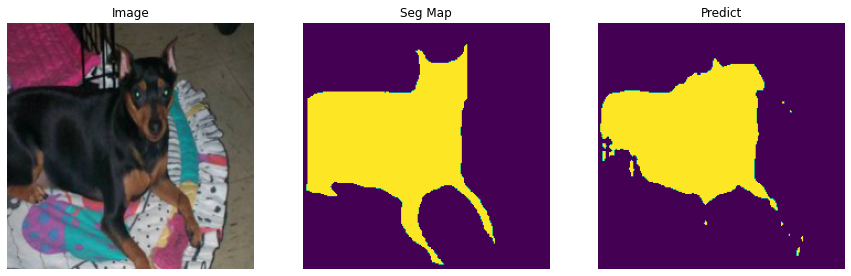

 Epoch: [13/30] - Train
Current Step: 50 	Train Loss: 0.7141797518730164, Train Iou: 0.789446234703064
Current Step: 100 	Train Loss: 0.7085311615467071, Train Iou: 0.7902176380157471
Current Step: 150 	Train Loss: 0.7225438463687897, Train Iou: 0.779452383518219
Current Step: 200 	Train Loss: 0.7101454186439514, Train Iou: 0.785590648651123
 Epoch: [13/30] - Validation
Validation step: Val Loss: 0.7684273719787598, Val Iou: 0.7471565008163452


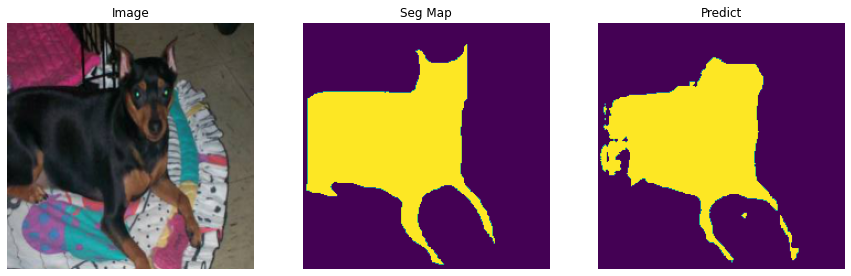

 Epoch: [14/30] - Train
Current Step: 50 	Train Loss: 0.7040380036830902, Train Iou: 0.8037211894989014
Current Step: 100 	Train Loss: 0.7056582593917846, Train Iou: 0.7961208820343018
Current Step: 150 	Train Loss: 0.7064032924175262, Train Iou: 0.7899940609931946
Current Step: 200 	Train Loss: 0.7062429702281952, Train Iou: 0.7959044575691223
 Epoch: [14/30] - Validation
Validation step: Val Loss: 0.7270622253417969, Val Iou: 0.7646970748901367


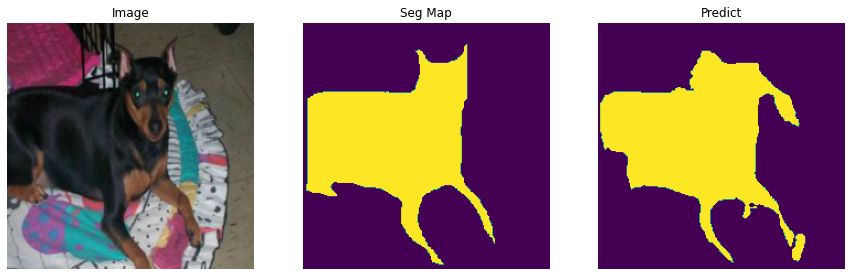

 Epoch: [15/30] - Train
Current Step: 50 	Train Loss: 0.7004221594333648, Train Iou: 0.8045191764831543
Current Step: 100 	Train Loss: 0.6957689440250396, Train Iou: 0.8083555698394775
Current Step: 150 	Train Loss: 0.6967354726791382, Train Iou: 0.8035916686058044
Current Step: 200 	Train Loss: 0.7008870565891265, Train Iou: 0.8001782894134521
 Epoch: [15/30] - Validation
Validation step: Val Loss: 0.7064034342765808, Val Iou: 0.7897504568099976


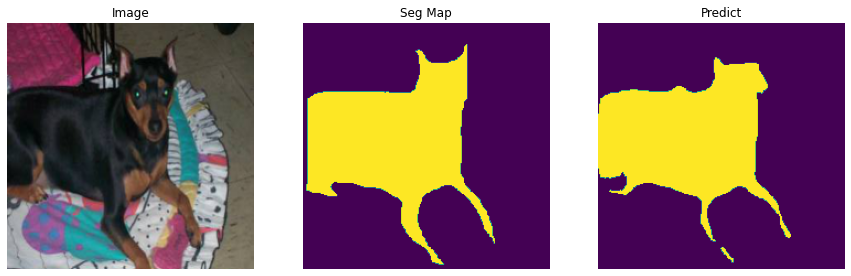

 Epoch: [16/30] - Train
Current Step: 50 	Train Loss: 0.6927683413028717, Train Iou: 0.815199613571167
Current Step: 100 	Train Loss: 0.7004615235328674, Train Iou: 0.8010198473930359
Current Step: 150 	Train Loss: 0.6848841106891632, Train Iou: 0.8183510303497314
Current Step: 200 	Train Loss: 0.6891077733039856, Train Iou: 0.8148632049560547
 Epoch: [16/30] - Validation
Validation step: Val Loss: 0.6993209719657898, Val Iou: 0.7981910109519958


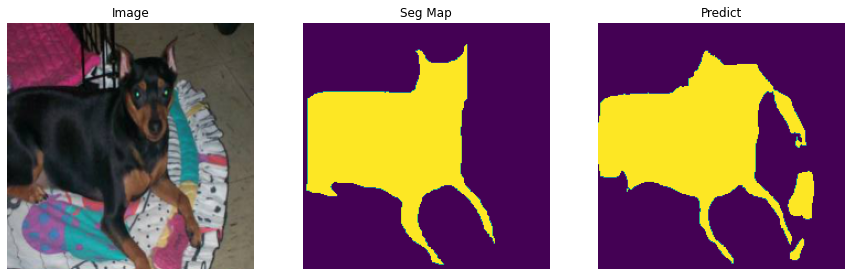

 Epoch: [17/30] - Train
Current Step: 50 	Train Loss: 0.6735832726955414, Train Iou: 0.8275065422058105
Current Step: 100 	Train Loss: 0.6856076538562774, Train Iou: 0.8180361390113831
Current Step: 150 	Train Loss: 0.6799214589595795, Train Iou: 0.8292863368988037
Current Step: 200 	Train Loss: 0.6903905987739563, Train Iou: 0.8182373046875
 Epoch: [17/30] - Validation
Validation step: Val Loss: 0.7079401612281799, Val Iou: 0.7938811779022217


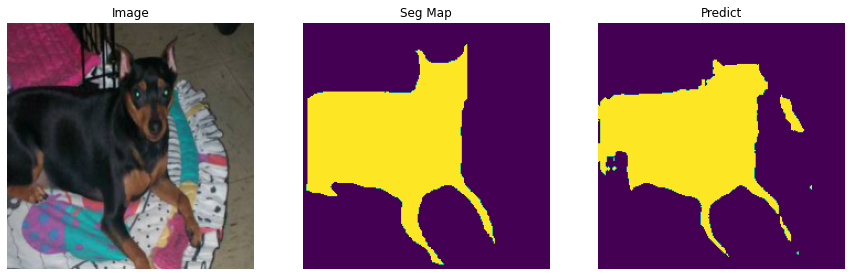

 Epoch: [18/30] - Train
Current Step: 50 	Train Loss: 0.6596780049800873, Train Iou: 0.8448021411895752
Current Step: 100 	Train Loss: 0.664398353099823, Train Iou: 0.8389901518821716
Current Step: 150 	Train Loss: 0.6873773455619812, Train Iou: 0.8246662020683289
Current Step: 200 	Train Loss: 0.6825647294521332, Train Iou: 0.8279404640197754
 Epoch: [18/30] - Validation
Validation step: Val Loss: 0.7060608863830566, Val Iou: 0.7881489396095276


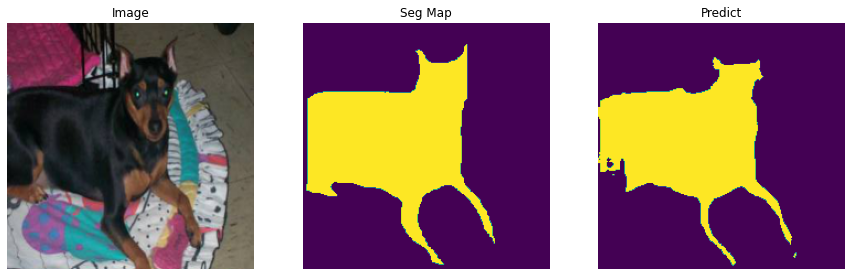

 Epoch: [19/30] - Train
Current Step: 50 	Train Loss: 0.661315530538559, Train Iou: 0.8464974164962769
Current Step: 100 	Train Loss: 0.6653192448616028, Train Iou: 0.8427857160568237
Current Step: 150 	Train Loss: 0.6639072847366333, Train Iou: 0.8446794152259827
Current Step: 200 	Train Loss: 0.6620125782489776, Train Iou: 0.8459406495094299
 Epoch: [19/30] - Validation
Validation step: Val Loss: 0.7048681378364563, Val Iou: 0.8010584115982056


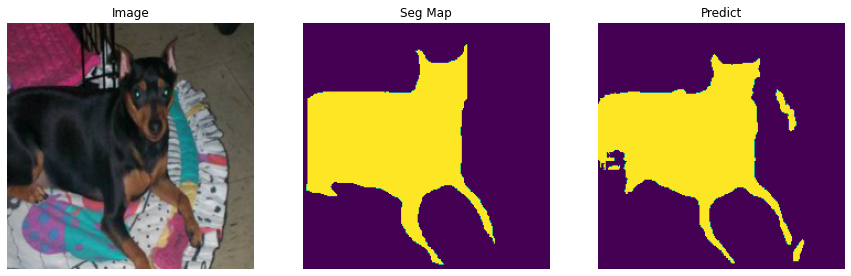

 Epoch: [20/30] - Train
Current Step: 50 	Train Loss: 0.6518211197853089, Train Iou: 0.8584021925926208
Current Step: 100 	Train Loss: 0.6578857409954071, Train Iou: 0.8494977355003357
Current Step: 150 	Train Loss: 0.6586758863925933, Train Iou: 0.8537725806236267
Current Step: 200 	Train Loss: 0.6576681852340698, Train Iou: 0.8508140444755554
 Epoch: [20/30] - Validation
Validation step: Val Loss: 0.7004022598266602, Val Iou: 0.8065971732139587


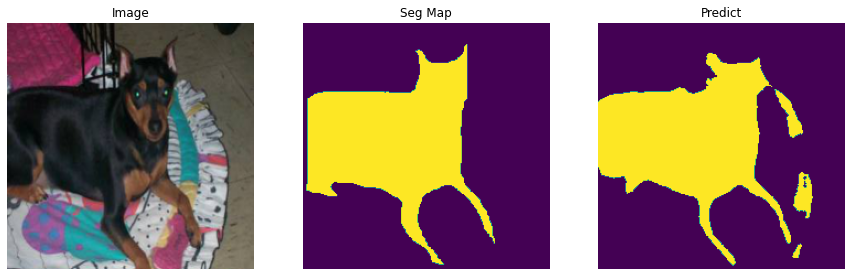

 Epoch: [21/30] - Train
Current Step: 50 	Train Loss: 0.653223088979721, Train Iou: 0.8605139851570129
Current Step: 100 	Train Loss: 0.6543608987331391, Train Iou: 0.853960394859314
Current Step: 150 	Train Loss: 0.6603019142150879, Train Iou: 0.8480901122093201
Current Step: 200 	Train Loss: 0.6444983518123627, Train Iou: 0.8679124712944031
 Epoch: [21/30] - Validation
Validation step: Val Loss: 0.7049863934516907, Val Iou: 0.8091742396354675


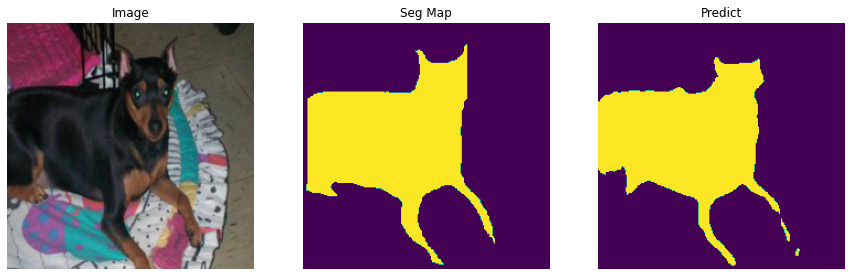

 Epoch: [22/30] - Train
Current Step: 50 	Train Loss: 0.635805367231369, Train Iou: 0.8766677975654602
Current Step: 100 	Train Loss: 0.6395752394199371, Train Iou: 0.873920202255249
Current Step: 150 	Train Loss: 0.6422846102714539, Train Iou: 0.8666487336158752
Current Step: 200 	Train Loss: 0.6496626329421997, Train Iou: 0.8633511066436768
 Epoch: [22/30] - Validation
Validation step: Val Loss: 0.7388649582862854, Val Iou: 0.7792980670928955


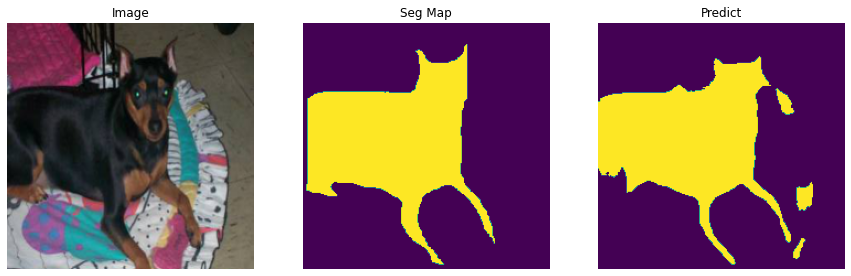

 Epoch: [23/30] - Train
Current Step: 50 	Train Loss: 0.6302524471282959, Train Iou: 0.8758411407470703
Current Step: 100 	Train Loss: 0.6424410235881806, Train Iou: 0.8681149482727051
Current Step: 150 	Train Loss: 0.6446308970451355, Train Iou: 0.8717793226242065
Current Step: 200 	Train Loss: 0.6450069046020508, Train Iou: 0.8690698146820068
 Epoch: [23/30] - Validation
Validation step: Val Loss: 0.7048484086990356, Val Iou: 0.8048020005226135


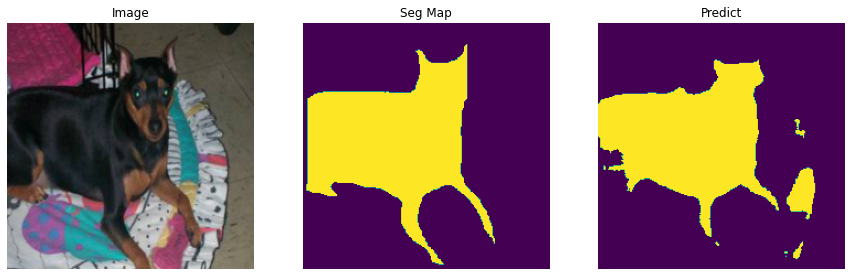

 Epoch: [24/30] - Train
Current Step: 50 	Train Loss: 0.6267234003543853, Train Iou: 0.8835462331771851
Current Step: 100 	Train Loss: 0.6296890604496003, Train Iou: 0.8876157402992249
Current Step: 150 	Train Loss: 0.6295448076725007, Train Iou: 0.8830541372299194
Current Step: 200 	Train Loss: 0.6263330054283142, Train Iou: 0.8858107924461365
 Epoch: [24/30] - Validation
Validation step: Val Loss: 0.7008832097053528, Val Iou: 0.8125172257423401


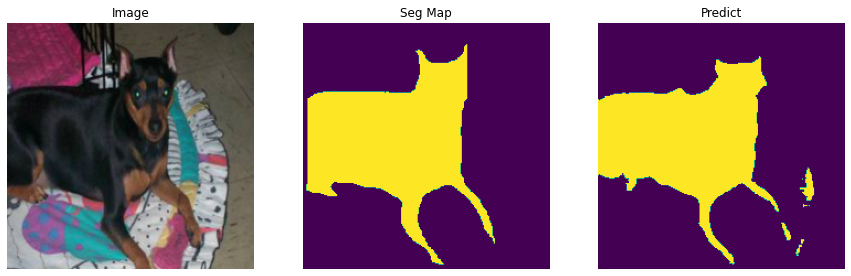

 Epoch: [25/30] - Train
Current Step: 50 	Train Loss: 0.6307039988040924, Train Iou: 0.8896801471710205
Current Step: 100 	Train Loss: 0.6300356256961822, Train Iou: 0.879536509513855
Current Step: 150 	Train Loss: 0.6290610086917877, Train Iou: 0.8835208415985107
Current Step: 200 	Train Loss: 0.6320302355289459, Train Iou: 0.8774572014808655
 Epoch: [25/30] - Validation
Validation step: Val Loss: 0.7331070303916931, Val Iou: 0.803244948387146


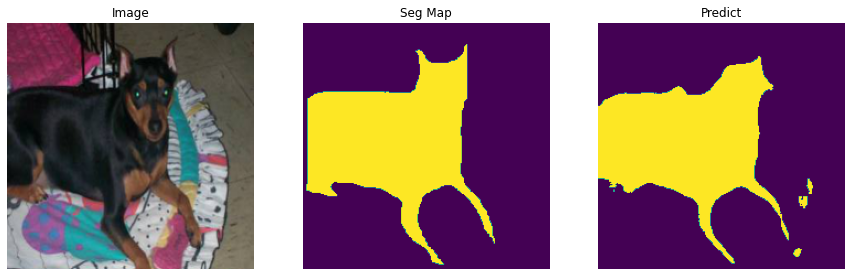

 Epoch: [26/30] - Train
Current Step: 50 	Train Loss: 0.6349837958812714, Train Iou: 0.8855639100074768
Current Step: 100 	Train Loss: 0.6267808139324188, Train Iou: 0.8872460126876831
Current Step: 150 	Train Loss: 0.6157139062881469, Train Iou: 0.8929653763771057
Current Step: 200 	Train Loss: 0.6194171154499054, Train Iou: 0.8919031620025635
 Epoch: [26/30] - Validation
Validation step: Val Loss: 0.6995372176170349, Val Iou: 0.8163228034973145


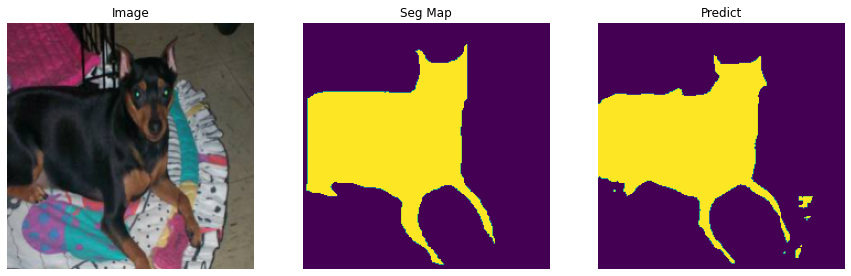

 Epoch: [27/30] - Train
Current Step: 50 	Train Loss: 0.6219483923912048, Train Iou: 0.8946501016616821
Current Step: 100 	Train Loss: 0.6205952453613282, Train Iou: 0.8972525000572205
Current Step: 150 	Train Loss: 0.6209511077404022, Train Iou: 0.8946735858917236
Current Step: 200 	Train Loss: 0.6103180623054505, Train Iou: 0.900684118270874
 Epoch: [27/30] - Validation
Validation step: Val Loss: 0.7092723846435547, Val Iou: 0.8097772598266602


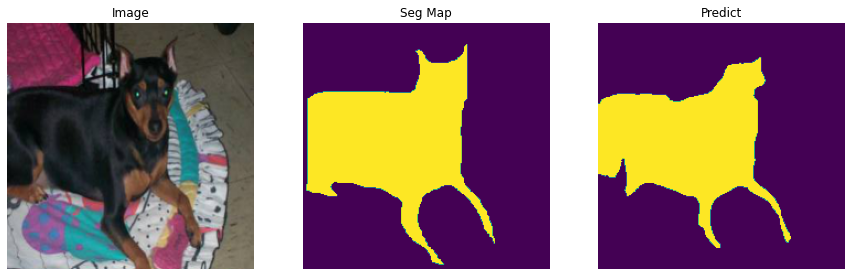

 Epoch: [28/30] - Train
Current Step: 50 	Train Loss: 0.6106437921524048, Train Iou: 0.903057873249054
Current Step: 100 	Train Loss: 0.6091877150535584, Train Iou: 0.9056038856506348
Current Step: 150 	Train Loss: 0.6185943031311035, Train Iou: 0.8998841643333435
Current Step: 200 	Train Loss: 0.6179090428352356, Train Iou: 0.8996649980545044
 Epoch: [28/30] - Validation
Validation step: Val Loss: 0.7256531119346619, Val Iou: 0.8052650690078735


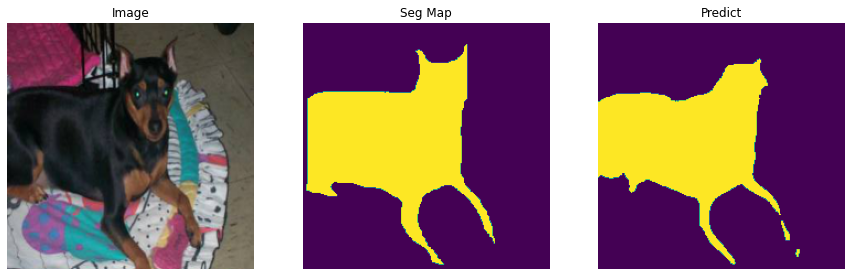

 Epoch: [29/30] - Train
Current Step: 50 	Train Loss: 0.6127163696289063, Train Iou: 0.9057154655456543
Current Step: 100 	Train Loss: 0.6057101011276245, Train Iou: 0.9084272980690002
Current Step: 150 	Train Loss: 0.6167020893096924, Train Iou: 0.9060705304145813
Current Step: 200 	Train Loss: 0.6032949584722519, Train Iou: 0.9086511135101318
 Epoch: [29/30] - Validation
Validation step: Val Loss: 0.7089915871620178, Val Iou: 0.8196920156478882


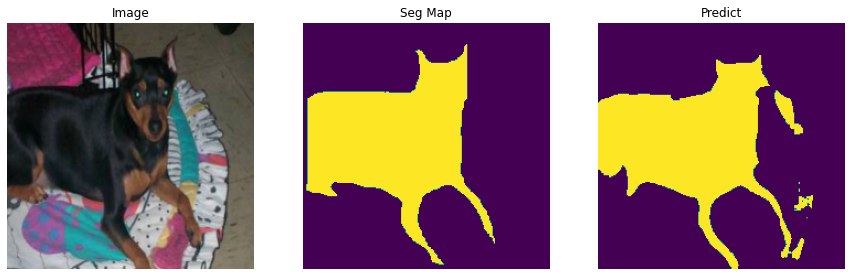

 Epoch: [30/30] - Train
Current Step: 50 	Train Loss: 0.6078434443473816, Train Iou: 0.9093922972679138
Current Step: 100 	Train Loss: 0.6170558774471283, Train Iou: 0.908008337020874
Current Step: 150 	Train Loss: 0.6012845003604889, Train Iou: 0.9088985323905945
Current Step: 200 	Train Loss: 0.6144085431098938, Train Iou: 0.901725709438324
 Epoch: [30/30] - Validation
Validation step: Val Loss: 0.7222620248794556, Val Iou: 0.8067905306816101


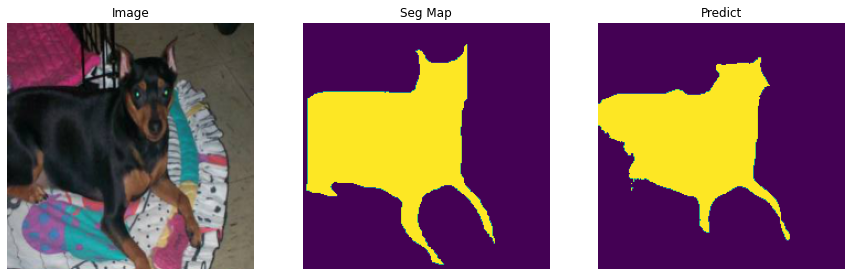

In [17]:
train_result = []
val_result = []

for epoch in range(1, epochs + 1):
    train_loss, train_iou = train(epoch, model, train_loader, loss_fn, optimizer)
    val_loss, val_iou = validation(epoch, model, val_loader, loss_fn)
    
    train_result.append([train_loss, train_iou])
    val_result.append([val_loss, val_iou])

# Visualization Loss & IOU

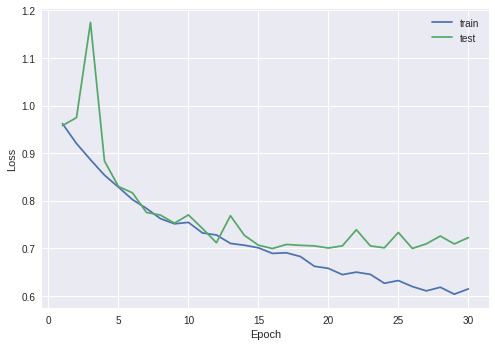

In [18]:
plt.style.use('seaborn')
plt.plot([i for i in range(1, len(train_result) + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(1, len(val_result) + 1)], [i[0] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

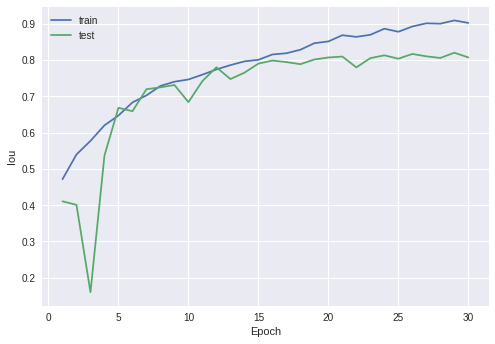

In [19]:
plt.plot([i for i in range(1, len(train_result) + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(1, len(val_result) + 1)], [i[1] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Iou")
plt.legend(["train", "test"])
plt.show()

# Test Model & Save



Test Iou:  tensor(0.7806)


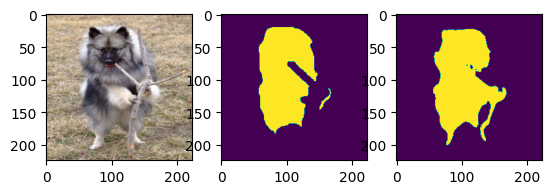

In [20]:
image, seg = next(iter(val_loader))
img, seg_map = image[8], seg[8]

plt.style.use('default')
plt.subplot(131)
plt.imshow(torch.permute(img, (1, 2, 0)))
plt.subplot(132)
plt.imshow(torch.squeeze(seg_map, 0))

model.eval()
out = model(torch.unsqueeze(img, 0).to(device))
out = (out >= 0.5).int()
print('Test Iou: ', iou(out, seg_map))

out = torch.squeeze(out, 0)
out = torch.squeeze(out, 0)

plt.subplot(133)
plt.imshow(out.detach().cpu().numpy())
plt.show()

In [21]:
PATH = '/content/drive/MyDrive/Models/'
torch.save(model, PATH + 'Segmentation_model.ckpt')